Hahua Mykyta DA-22 Machine Learning Lab#2

First of all lets download and read data from google drive urls, i uploaded them on google drive

In [1]:
import os
import gdown
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

train_url = 'https://drive.google.com/uc?id=1wCKXZWpYEysIFn1F74R9pTOt6aFasKTy'
test_url = 'https://drive.google.com/uc?id=1gTuliILSkSw9JYSW_RhpxcnqKS3Q-PMM'

train = 'application_train.csv'
test = 'application_test.csv'

if not os.path.exists(train):
    print(f"{train} not found. Downloading...")
    gdown.download(train_url, train, quiet=False)
else:
    print(f"{train} already exists. Skipping download.")

if not os.path.exists(test):
    print(f"{test} not found. Downloading...")
    gdown.download(test_url, test, quiet=False)
else:
    print(f"{test} already exists. Skipping download.")

df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

/Users/nikitagagua/PycharmProjects/machine learning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


application_train.csv not found. Downloading...


Downloading...
From (original): https://drive.google.com/uc?id=1wCKXZWpYEysIFn1F74R9pTOt6aFasKTy
From (redirected): https://drive.google.com/uc?id=1wCKXZWpYEysIFn1F74R9pTOt6aFasKTy&confirm=t&uuid=1770afb6-c5ee-4c87-870d-e52702e00296
To: /Users/nikitagagua/PycharmProjects/machine learning/application_train.csv
100%|██████████| 166M/166M [00:16<00:00, 9.93MB/s] 


application_test.csv not found. Downloading...


Downloading...
From: https://drive.google.com/uc?id=1gTuliILSkSw9JYSW_RhpxcnqKS3Q-PMM
To: /Users/nikitagagua/PycharmProjects/machine learning/application_test.csv
100%|██████████| 26.6M/26.6M [00:02<00:00, 9.77MB/s]


get info about table

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


get info about feature types

In [3]:
df_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

lets get sample of 15 rows 

In [4]:
print(df_train.shape)
df_train.head()
df_train.sample(15)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
180487,309169,0,Cash loans,F,N,Y,0,202500.0,239850.0,23494.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
238856,376688,0,Revolving loans,F,N,Y,1,112500.0,337500.0,16875.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
72949,184587,0,Cash loans,F,N,Y,0,112500.0,729792.0,39591.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
49291,157059,0,Revolving loans,M,Y,N,2,810000.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
179090,307531,1,Cash loans,M,N,N,0,135000.0,485640.0,38938.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
262384,403746,0,Cash loans,M,Y,Y,0,270000.0,1125000.0,37309.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
114966,233306,0,Cash loans,M,Y,Y,0,270000.0,855000.0,36355.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
254237,394191,0,Cash loans,F,Y,Y,1,189000.0,1013818.5,51894.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0
234755,371937,0,Cash loans,F,N,Y,0,225000.0,679500.0,36202.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
20344,123735,0,Cash loans,M,Y,Y,0,157500.0,604152.0,22518.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0


check for missing values:

In [5]:

df_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

here we are going to delete features where missing ratio of feature is greater than 10%

In [6]:
missing_ratio = df_train.isnull().sum() / len(df_train) * 100
print(missing_ratio[missing_ratio > 0].sort_values(ascending=False))

threshold = 0.1
columns_to_drop = missing_ratio[missing_ratio > threshold * 100].index
df_train.drop(columns=columns_to_drop, axis=1, inplace=True)
df_test.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Удалены колонки: {columns_to_drop}")

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
                              ...    
EXT_SOURCE_2                 0.214626
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64
Удалены колонки: Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRAN

here i will delete pointless features in my honest opinion

In [7]:
to_exclude= {"CNT_FAM_MEMBERS", "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4",
                    "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9",
                    "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14",
                    "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19",
                    "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21", "REG_REGION_NOT_LIVE_REGION", "REGION_POPULATION_RELATIVE",
                    "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION",
                    "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "FLAG_PHONE",
                    "FLAG_EMAIL", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"}

for column in to_exclude:
    df_train = df_train.drop(columns=column)
    df_test = df_test.drop(columns=column)

df_train.sample(15)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
260601,401589,0,Cash loans,F,N,Y,0,85500.0,509922.0,26788.5,...,0,1,2,2,0.714596,1.0,0.0,0.0,0.0,-290.0
69205,180259,0,Cash loans,M,N,Y,0,166500.0,653328.0,25443.0,...,0,1,3,3,0.173023,0.0,0.0,0.0,0.0,-2571.0
290038,436010,0,Cash loans,M,N,N,0,225000.0,675000.0,32602.5,...,0,1,2,2,0.539891,7.0,0.0,7.0,0.0,-826.0
29739,134529,0,Revolving loans,F,N,Y,0,67500.0,247500.0,12375.0,...,0,1,2,2,0.429911,0.0,0.0,0.0,0.0,-1811.0
277338,421369,0,Cash loans,F,N,Y,1,180000.0,1011955.5,43006.5,...,0,1,2,2,0.610670,0.0,0.0,0.0,0.0,-2459.0
281198,425771,0,Cash loans,F,N,N,0,157500.0,760225.5,51138.0,...,0,1,2,2,0.635504,1.0,0.0,1.0,0.0,-1099.0
154502,279072,0,Cash loans,F,N,Y,0,72000.0,188685.0,9207.0,...,0,1,2,2,0.379378,2.0,0.0,2.0,0.0,0.0
100923,217183,0,Cash loans,F,N,Y,1,112500.0,679500.0,45724.5,...,1,1,2,2,0.648425,0.0,0.0,0.0,0.0,-418.0
222510,357743,0,Cash loans,F,N,N,0,157500.0,2517300.0,66532.5,...,1,1,3,3,0.344893,0.0,0.0,0.0,0.0,-778.0
149722,273580,0,Cash loans,F,N,N,1,121500.0,454500.0,16695.0,...,1,1,3,3,0.497165,0.0,0.0,0.0,0.0,-21.0


next i will divide categorical and numerical columns

In [8]:
categorical_columns = {"TARGET", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "FLAG_MOBIL", "FLAG_EMP_PHONE",
                        "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY",
                        "NAME_CONTRACT_TYPE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
                        "NAME_HOUSING_TYPE"}

numerical_columns = [col for col in df_train.columns if col not in categorical_columns]


def print_unique():
    for feature in categorical_columns:
        if feature in df_train.columns:
            unique_values = df_train[feature].unique()
            print(f"Unique values for {feature}: {unique_values}")
        else:
            print(f"Feature {feature} not found in the DataFrame.")


print_unique()

Unique values for CODE_GENDER: ['M' 'F' 'XNA']
Unique values for NAME_EDUCATION_TYPE: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Unique values for FLAG_EMP_PHONE: [1 0]
Unique values for FLAG_CONT_MOBILE: [1 0]
Unique values for FLAG_MOBIL: [1 0]
Unique values for FLAG_WORK_PHONE: [0 1]
Unique values for NAME_CONTRACT_TYPE: ['Cash loans' 'Revolving loans']
Unique values for REGION_RATING_CLIENT_W_CITY: [2 1 3]
Unique values for FLAG_OWN_CAR: ['N' 'Y']
Unique values for NAME_INCOME_TYPE: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
Unique values for TARGET: [1 0]
Unique values for REGION_RATING_CLIENT: [2 1 3]
Unique values for NAME_HOUSING_TYPE: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
Unique values for FLAG_OWN_REALTY: ['Y' 'N']
Unique values for NAME_FAMILY_STATUS: ['Sing

lets transform categorical features into numerical formats suitable for machine learning by mapping binary values (e.g., "Y"/"N" to 1/0) and ordinal values (e.g., education levels) to a defined priority scale. Additionally, it applies one-hot encoding to multi-class categorical variables to create new binary columns for each unique category.

In [9]:
df_train["FLAG_OWN_CAR"] = df_train["FLAG_OWN_CAR"].map({"N": 0, "Y": 1})
df_train["FLAG_OWN_REALTY"] = df_train["FLAG_OWN_REALTY"].map({"N": 0, "Y": 1})
df_train["NAME_CONTRACT_TYPE"] = df_train["NAME_CONTRACT_TYPE"].map({"Cash loans": 1, "Revolving loans": 0})
df_test["FLAG_OWN_CAR"] = df_test["FLAG_OWN_CAR"].map({"N": 0, "Y": 1})
df_test["FLAG_OWN_REALTY"] = df_test["FLAG_OWN_REALTY"].map({"N": 0, "Y": 1})
df_test["NAME_CONTRACT_TYPE"] = df_test["NAME_CONTRACT_TYPE"].map({"Cash loans": 1, "Revolving loans": 0})

education_priority = {
    "Lower secondary": 0,
    "Secondary / secondary special": 1,
    "Incomplete higher": 2,
    "Higher education": 3,
    "Academic degree": 4
}
df_train["NAME_EDUCATION_TYPE"] = df_train["NAME_EDUCATION_TYPE"].map(education_priority)
df_test["NAME_EDUCATION_TYPE"] = df_test["NAME_EDUCATION_TYPE"].map(education_priority)

df_train = pd.get_dummies(df_train, columns=[
    "NAME_HOUSING_TYPE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS"
])
df_test = pd.get_dummies(df_test, columns=[
    "NAME_HOUSING_TYPE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS"
])

categorical_int_columns = df_train.select_dtypes(include=['bool']).columns

These functions provide visualization tools for exploring numerical data: histograms display the distribution of features, boxplots reveal outliers and spread, and a heatmap shows correlations among variables in a dataset.

In [10]:
def plot_numerical_features_histogram(data, numerical_features, bins=30, figsize=(16, 20), color='g', xlabelsize=8,
                                      ylabelsize=8, title="Histograms of Numerical Features"):
    fig = data[numerical_features].hist(
        figsize=figsize,
        color=color,
        bins=bins,
        xlabelsize=xlabelsize,
        ylabelsize=ylabelsize
    )

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    plt.show()


def plot_boxplots(data, numerical_features, cols=2, figsize=(10, 4)):
    num_features = len(numerical_features)
    rows = math.ceil(num_features / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize[0] * cols, figsize[1] * rows))
    fig.tight_layout(pad=3.0)

    axes = axes.flatten() if num_features > 1 else [axes]

    for i, col in enumerate(numerical_features):
        sns.boxplot(x=data[col], ax=axes[i], color='skyblue')
        axes[i].set_title(f'Boxplot for {col}', fontsize=10)
        axes[i].set_xlabel(col, fontsize=8)
        axes[i].set_ylabel('Value', fontsize=8)

    for j in range(len(numerical_features), len(axes)):
        axes[j].axis('off')

    plt.suptitle("Boxplots of Numerical Features", fontsize=16, y=1.02)
    plt.show()


def plot_correlation_heatmap(data, figsize=(16, 12), cmap="Greens", vmax=0.8, annot=True):
    corr_matrix = data.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_size_inches(20, 15)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap=cmap,
        vmax=vmax,
        square=True,
        annot=annot,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        ax=ax
    )

    plt.title("Correlation Heatmap", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()

lets get histogram

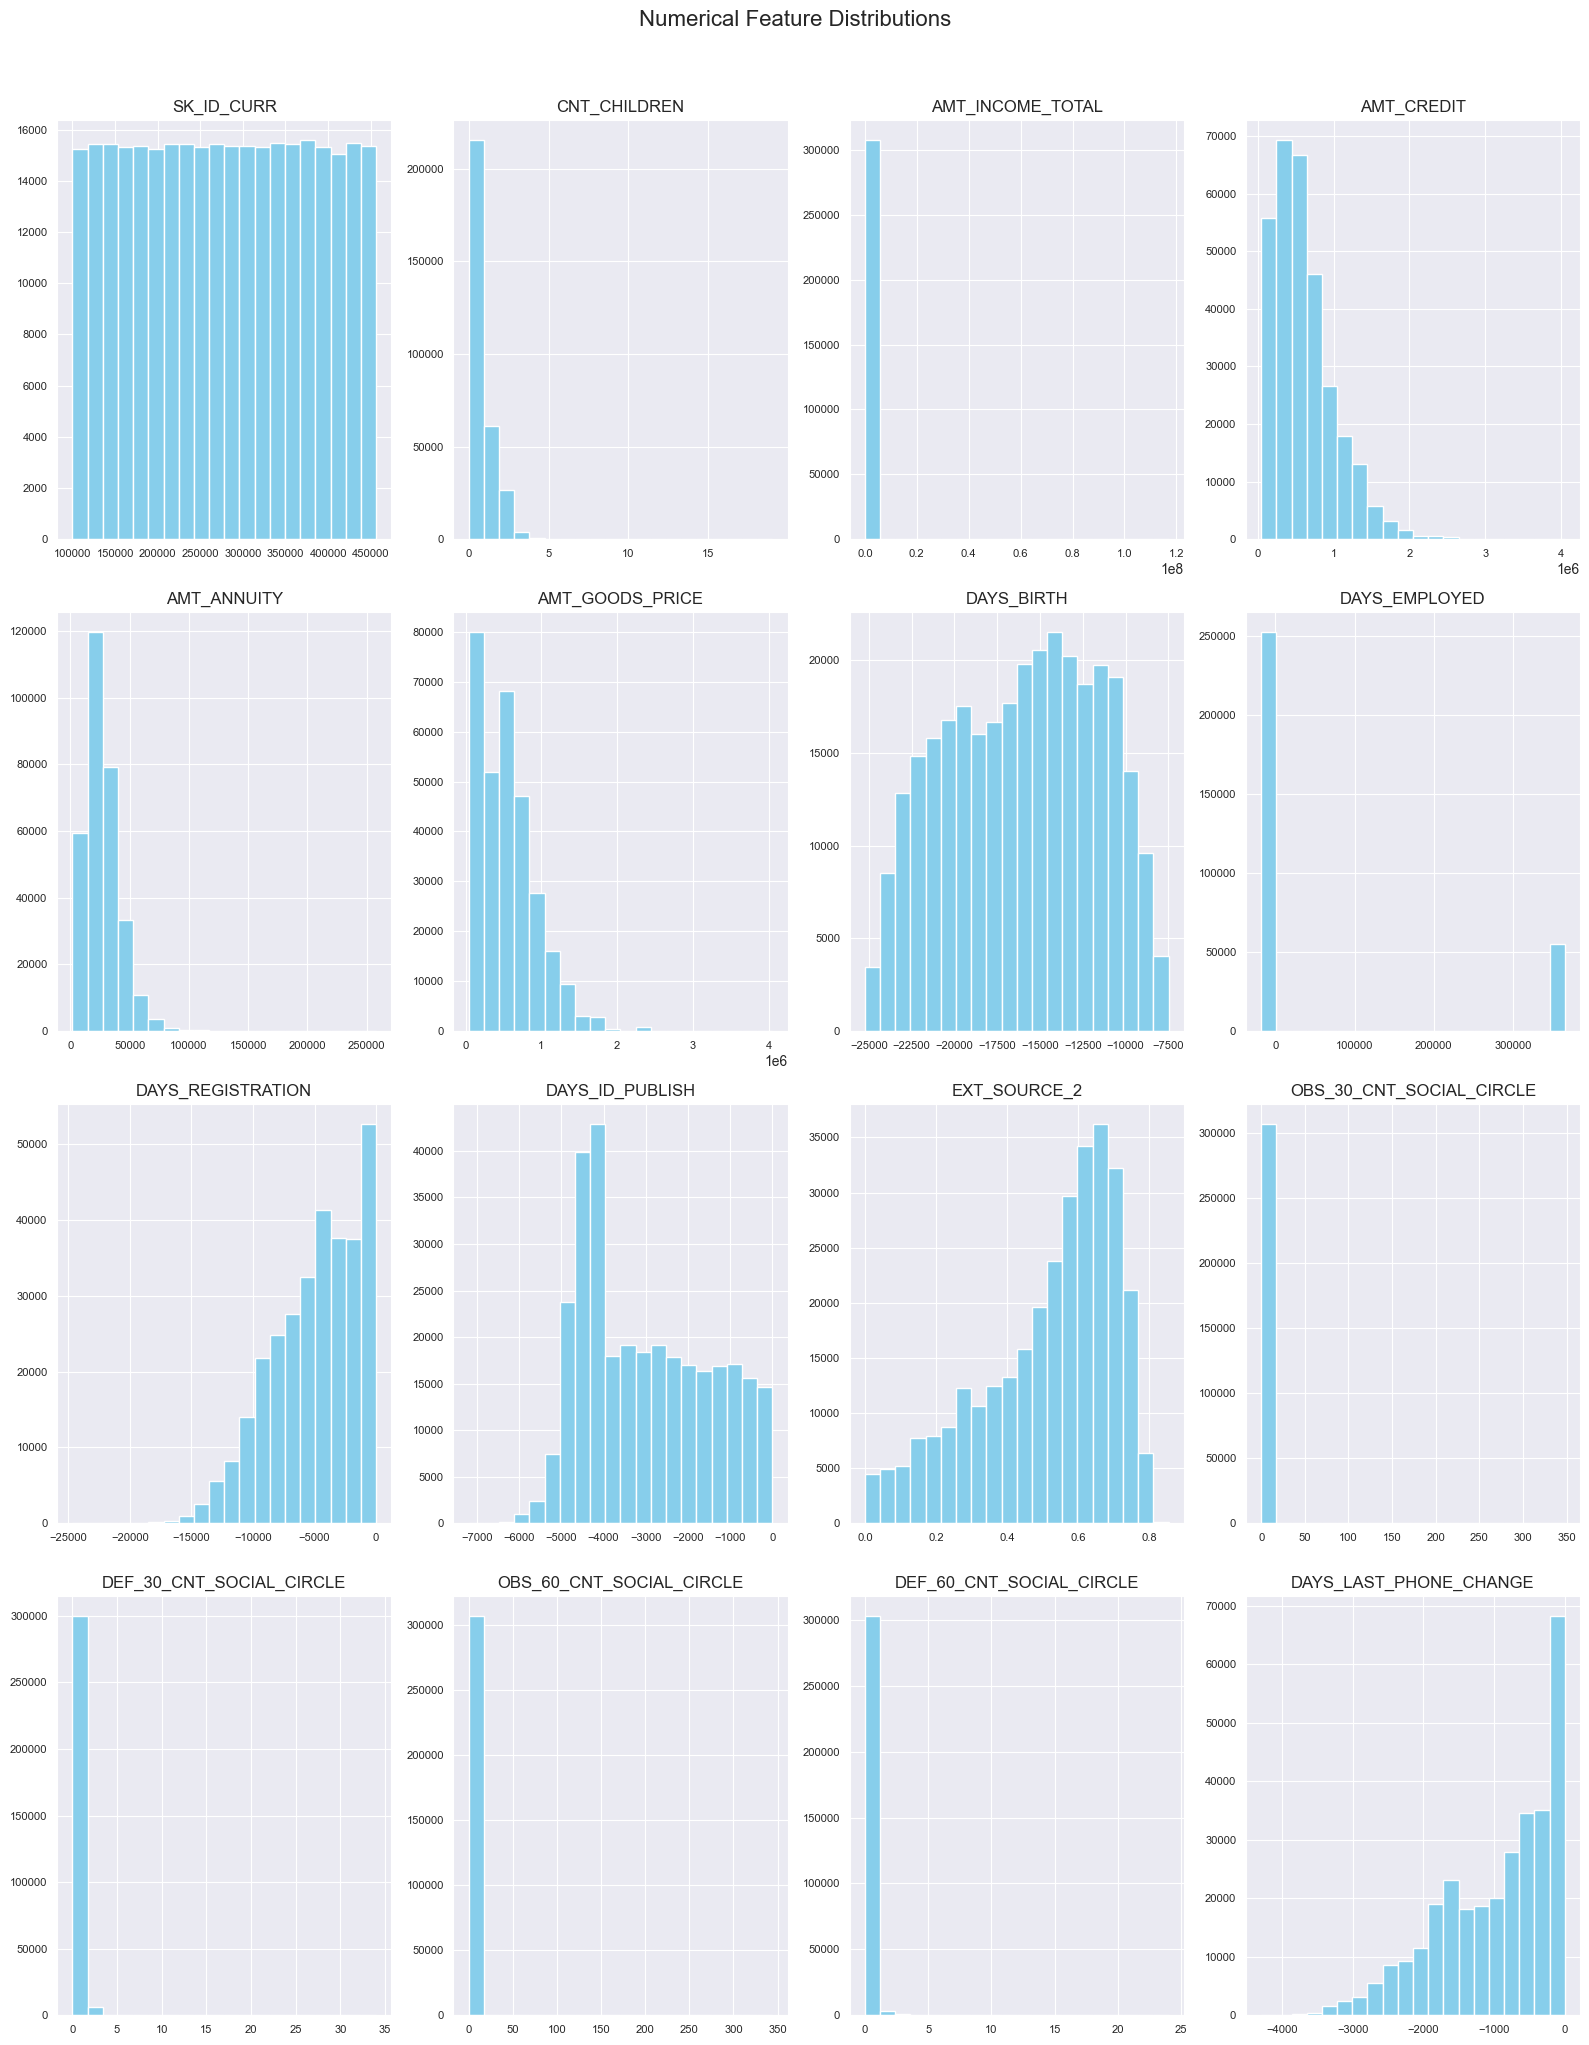

In [11]:
plot_numerical_features_histogram(df_train, numerical_columns, bins=20, color='skyblue',
                                  title="Numerical Feature Distributions")

lets extract and lists the names of all numerical columns

In [12]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


correlation heatmap:

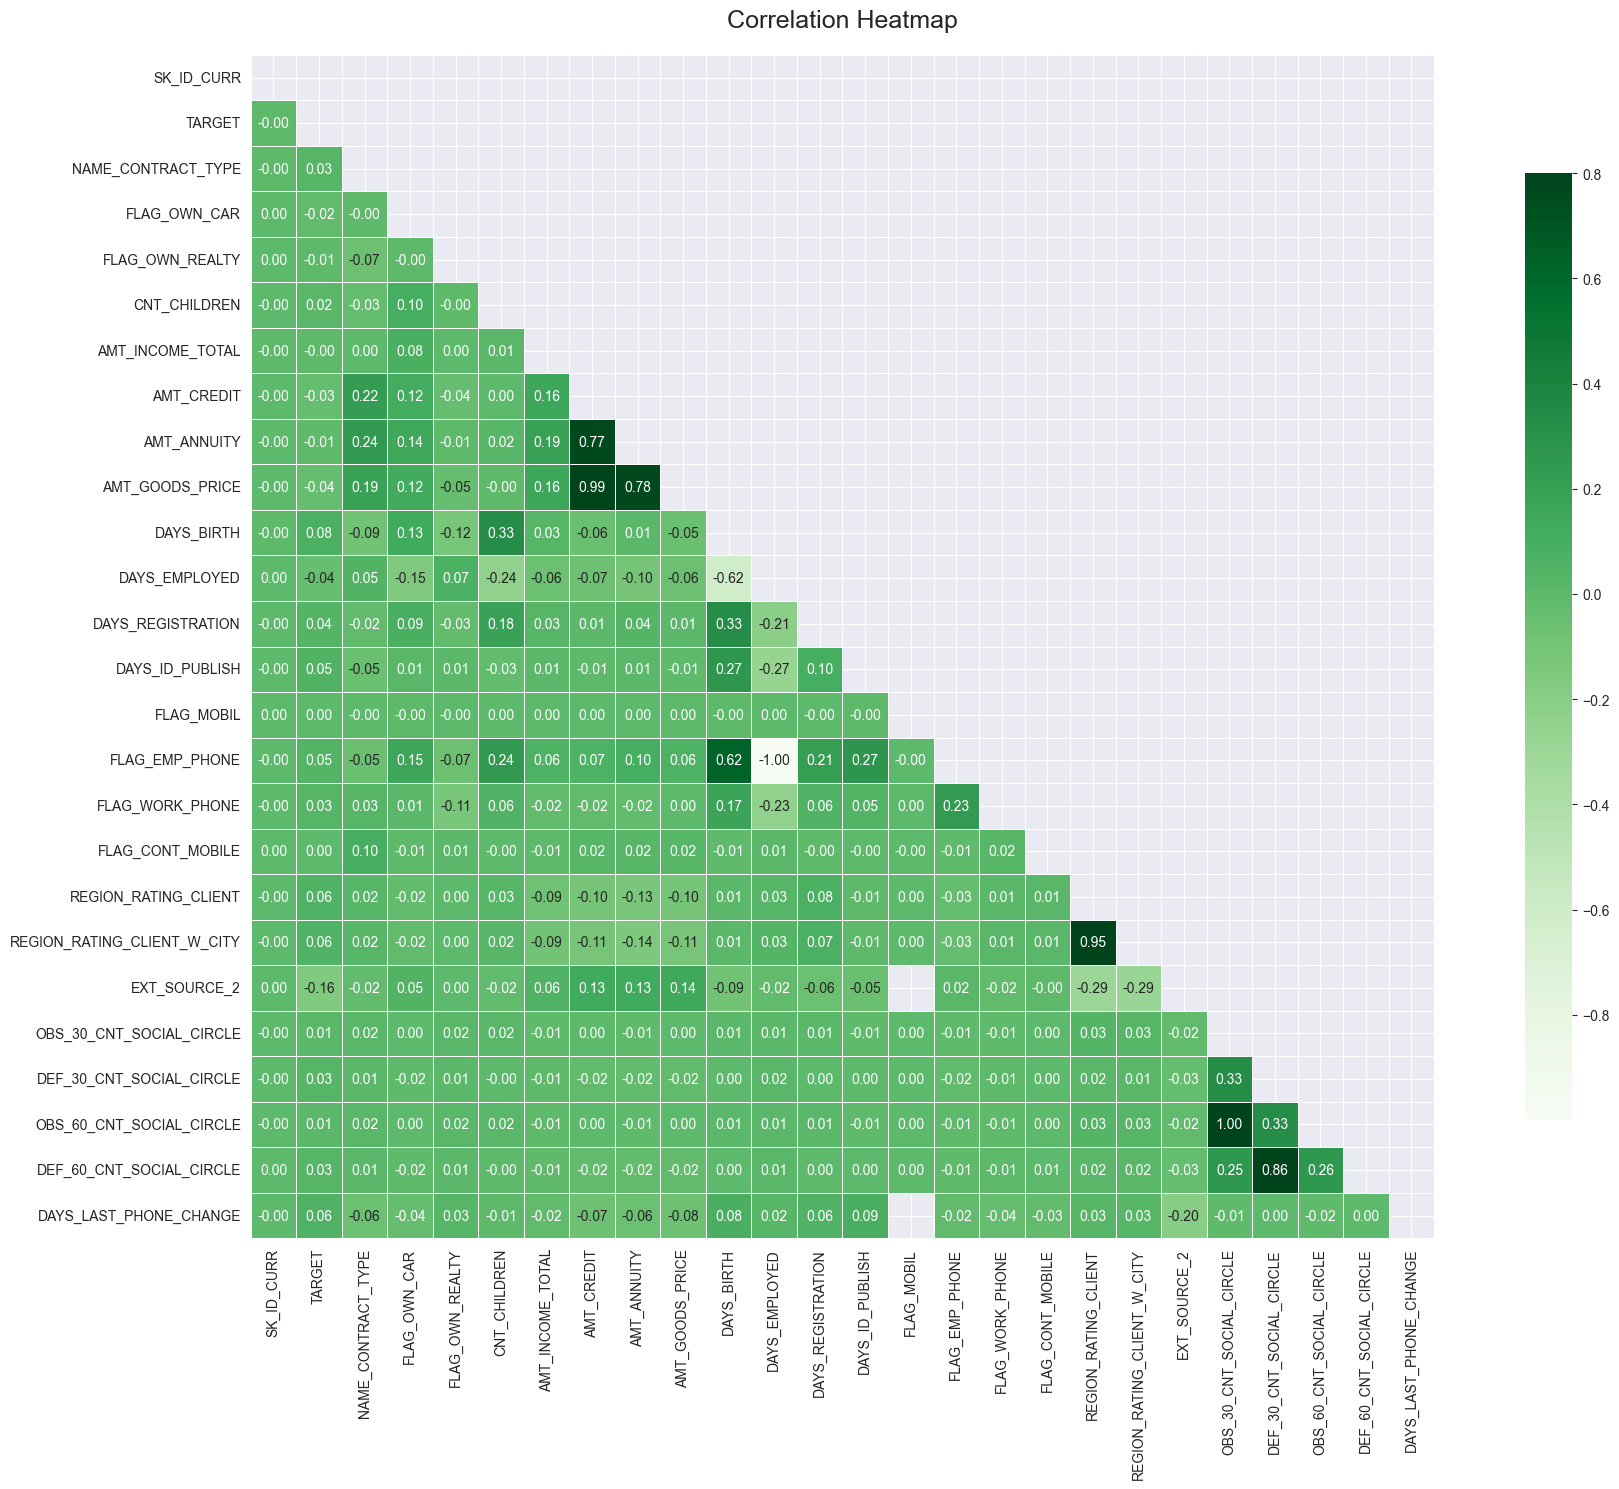

In [13]:
plot_correlation_heatmap(df_train[numerical_features])

then i will exclude columns which correlate the most

In [14]:
to_exclude = {"AMT_ANNUITY", "AMT_GOODS_PRICE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
              "NAME_INCOME_TYPE_Pensioner"}
df_train = df_train.drop(columns=to_exclude)
df_test = df_test.drop(columns=to_exclude)

lets see updated list of numerical features 

In [15]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


here we clean time-related features, compute a social circle median, drop unused columns, and plots numerical features with boxplots.

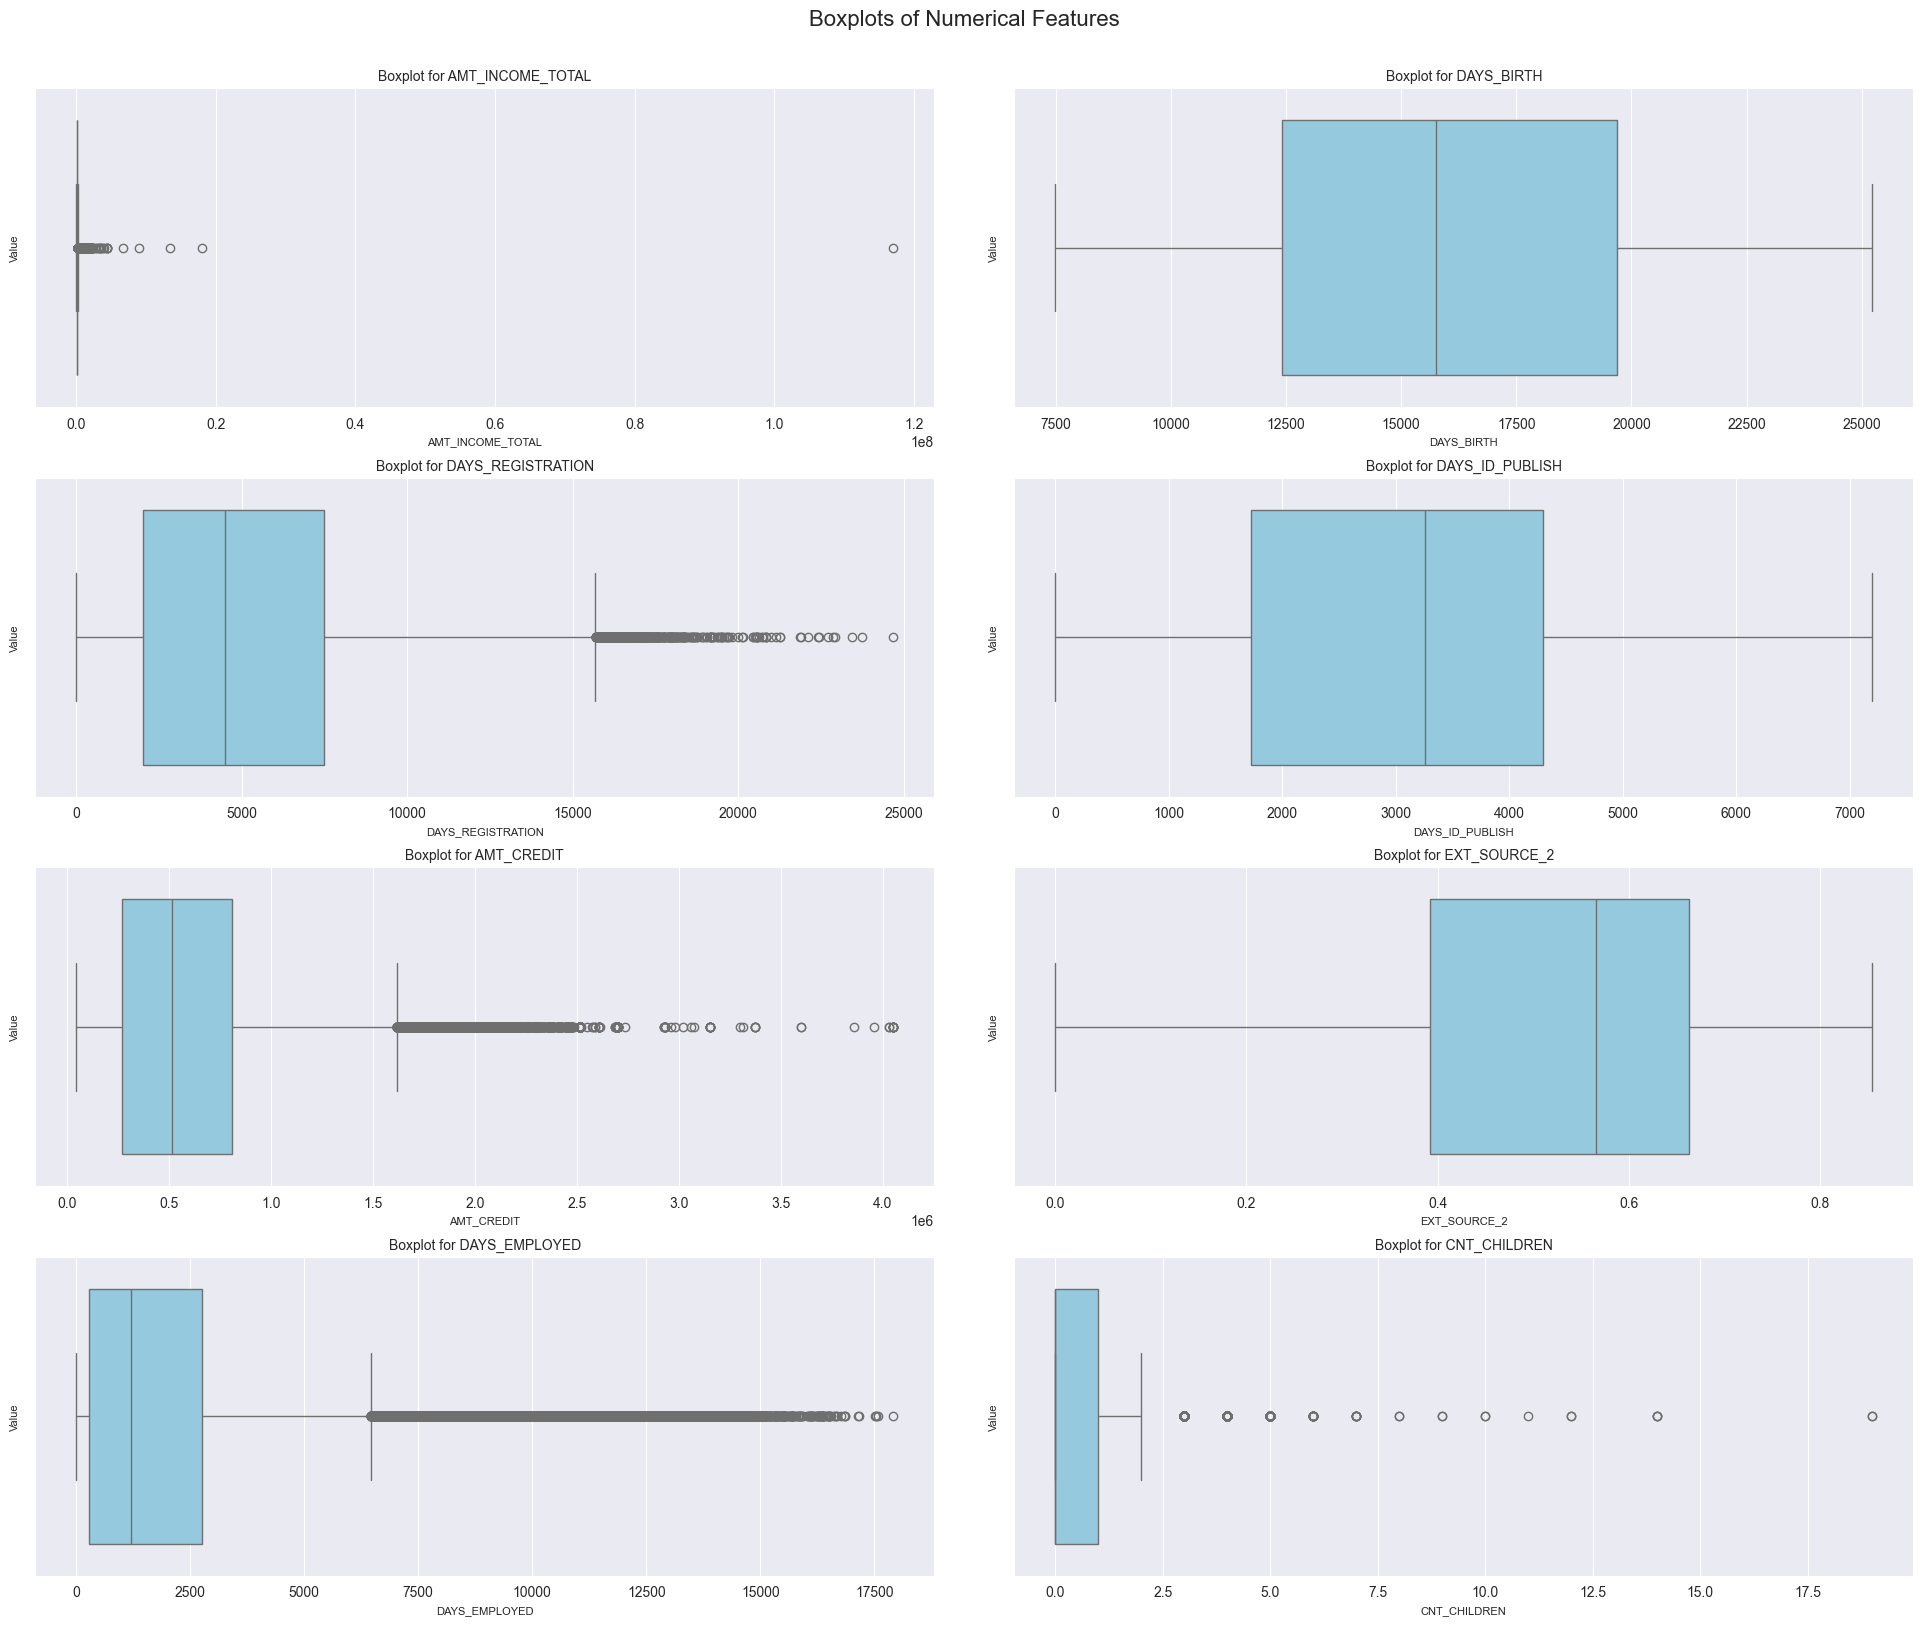

In [16]:
#OUTLIERS

df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, 0).abs()
df_train['DAYS_BIRTH'] = df_train['DAYS_BIRTH'].abs()
df_train['DAYS_REGISTRATION'] = df_train['DAYS_REGISTRATION'].abs()
df_train['DAYS_ID_PUBLISH'] = df_train['DAYS_ID_PUBLISH'].abs()
df_test['DAYS_EMPLOYED'] = df_test['DAYS_EMPLOYED'].replace(365243, 0).abs()
df_test['DAYS_BIRTH'] = df_test['DAYS_BIRTH'].abs()
df_test['DAYS_REGISTRATION'] = df_test['DAYS_REGISTRATION'].abs()
df_test['DAYS_ID_PUBLISH'] = df_test['DAYS_ID_PUBLISH'].abs()

df_test['SOCIAL_CIRCLE_MEDIAN'] = df_test[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE']].median(axis=1)
df_train['SOCIAL_CIRCLE_MEDIAN'] = df_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE']].median(axis=1)
df_train.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)
df_test.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)
numerical_features = {"CNT_CHILDREN", "AMT_INCOME_TOTAL", "DAYS_BIRTH", "AMT_CREDIT", "DAYS_EMPLOYED",
                      "DAYS_REGISTRATION", "EXT_SOURCE_2", "DAYS_ID_PUBLISH"}
plot_boxplots(df_train, numerical_features)

Here we prepare the data by splitting it into features and target, handle missing values, apply preprocessing for numerical and categorical columns, build a model pipeline with logistic regression, train the model, and evaluate its performance using ROC AUC.

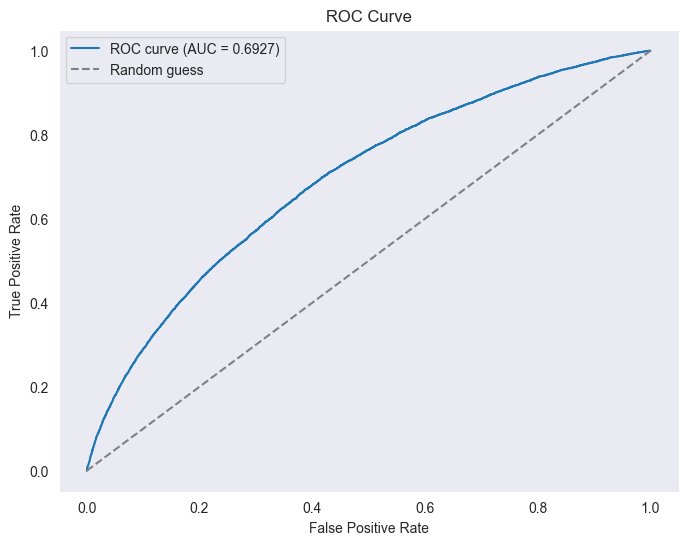

ROC AUC Score: 0.6927


In [17]:
from sklearn.impute import SimpleImputer

target_column = 'TARGET'
X = df_train.drop(columns=[target_column])
y = df_train[target_column]

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].median())
X[categorical_columns] = X[categorical_columns].fillna(X[categorical_columns].mode().iloc[0])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', StandardScaler())
        ]), numerical_columns),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_columns)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=200, solver='lbfgs', random_state=42))
])

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(train_x, train_y)

test_preds_proba = model.predict_proba(test_x)[:, 1]
roc_auc = roc_auc_score(test_y, test_preds_proba)

fpr, tpr, _ = roc_curve(test_y, test_preds_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

lets get result file

In [18]:
scaled_test_x = model.named_steps['preprocessor'].transform(df_test)
predicted_probabilities = model.named_steps['classifier'].predict_proba(scaled_test_x)[:, 1]

submission_df = pd.DataFrame({
    "SK_ID_CURR": df_test['SK_ID_CURR'],
    "TARGET": predicted_probabilities
}).to_csv

result: https://imgur.com/a/ISljz9s